In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from matplotlib import pyplot as plt

import math
import random

from config import client
from dataset import BeatmapSamples, BeatmapDataset, ShufflePairs
from model import Siamese
from pytorchtools import EarlyStopping
from utils import Stopwatch

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
osu_db = client['osu_mlpp_db1']

In [6]:
# sample = BeatmapSamples(osu_db.osu_beatmaps, osu_db.failtimes_dataset_500, 500)
# sample.clear_out()
# sample.generate()

In [7]:
learning_rate = .001
batch_size = 256
num_epochs = 1

In [8]:
train_dataset, test_dataset = BeatmapDataset.split(osu_db.failtimes_dataset_500, .8, transform = ShufflePairs())

train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(test_dataset, batch_size=batch_size)

In [10]:
timer = Stopwatch()
timer.start()
for a in iter(train_dataset):
    pass
timer.stop()
print(timer.elapsed)

0.02565531200033888
2.6941748899999993


In [11]:
timer = Stopwatch()
early_stopping = EarlyStopping(verbose=True)

n_total_steps = math.ceil(len(train_dataset) / batch_size)

model = Siamese().to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

avg_train_losses = []
avg_valid_losses = []

for epoch in range(num_epochs):
    timer.start()
    
    train_losses = []
    valid_losses = []
    
    model.train()
    for i, (x1, x2, labels) in enumerate(train_loader):
        
        x1 = x1.to(device)
        x2 = x2.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(x1, x2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    
    model.eval()
    for x1, x2, labels in valid_loader:
        
        x1 = x1.to(device)
        x2 = x2.to(device)
        labels = labels.to(device)
        
        outputs = model(x1, x2)
        loss = criterion(outputs, labels)
        
        valid_losses.append(loss.item())
    
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    
    timer.stop()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Time: {timer.elapsed:.2f}s')
    
    timer.reset()
    
    early_stopping(valid_loss, model)
    
    if early_stopping.early_stop:
        print("Stopping")
        break


0.37400157599988404
0.05154207700103086
Epoch [1/1], Train Loss: 1.3319, Valid Loss: 0.8489, Time: 3.55s
Validation loss decreased (inf --> 0.848876).  Saving model ...


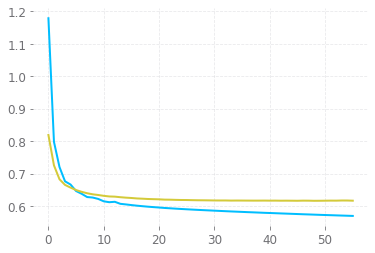

In [52]:
from matplotlib import pyplot as plt
plt.plot(avg_train_losses)
plt.plot(avg_valid_losses)

In [53]:
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

In [54]:
def accuracy(loader):
    with torch.no_grad():
        n_samples = 0
        n_correct = 0

        for (x1, x2, labels) in loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            labels = labels.to(device)
            
            n_samples += labels.size(0)

            out = (model(x1, x2) > .5).type(torch.float32)
            n_correct += (labels == out).type(torch.float32).sum().item()

        return n_correct/n_samples

tensor(-0.9241, device='cuda:0')


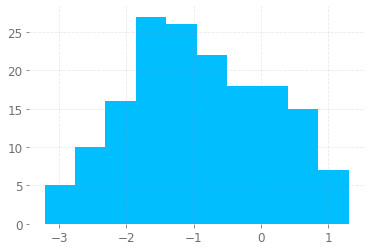

In [55]:
with torch.no_grad():
    batch1 = next(iter(train_loader))

    x1 = x1.to(device)
    x2 = x2.to(device)
    
    out1 = model.forward_one(x1)
    out2 = model.forward_one(x2)
    print(out1.flatten().mean())
    
    plt.hist(out1.flatten().tolist())

In [56]:
accuracy(train_loader)

0.6969195097714475

In [57]:
accuracy(valid_loader)

0.6729750189250567